# Exploratory data analysis of telecom customer dataser

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [6]:
file_path = r"dataset/telecom.xlsx"

# Define the sheet name to read data from
sheet_name = 'vw_ChurnData'

# Read the data from the specified sheet into a pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# ----------------- Basic Overview -----------------
print(df.shape)

(6007, 32)


In [7]:
# Data-Quality Check

In [8]:
df.duplicated().sum()

0

In [9]:
print(df.isnull().sum())

Customer_ID                    0
Gender                         0
Age                            0
Married                        0
State                          0
Number_of_Referrals            0
Tenure_in_Months               0
Value_Deal                     0
Phone_Service                  0
Multiple_Lines                 0
Internet_Service               0
Internet_Type                  0
Online_Security                0
Online_Backup                  0
Device_Protection_Plan         0
Premium_Support                0
Streaming_TV                   0
Streaming_Movies               0
Streaming_Music                0
Unlimited_Data                 0
Contract                       0
Paperless_Billing              0
Payment_Method                 0
Monthly_Charge                 0
Total_Charges                  0
Total_Refunds                  0
Total_Extra_Data_Charges       0
Total_Long_Distance_Charges    0
Total_Revenue                  0
Customer_Status                0
Churn_Cate

Numeric Columns: ['Age', 'Number_of_Referrals', 'Tenure_in_Months', 'Monthly_Charge', 'Total_Charges', 'Total_Refunds', 'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges', 'Total_Revenue']


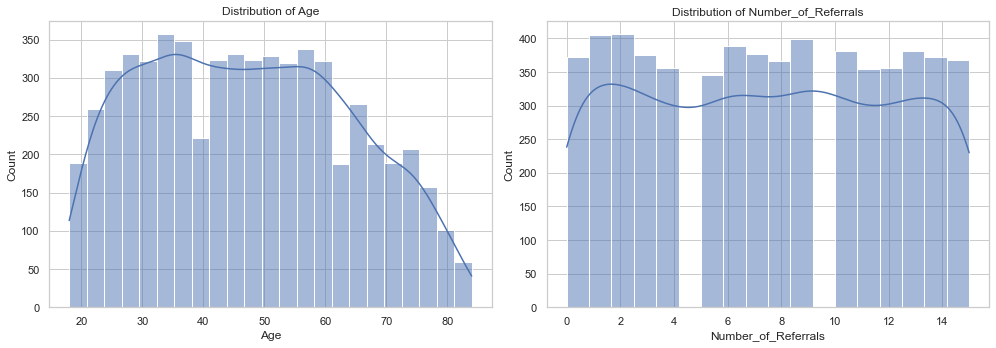

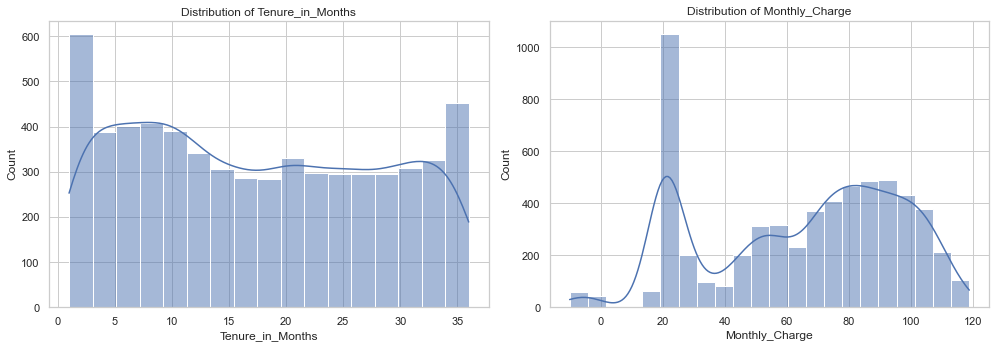

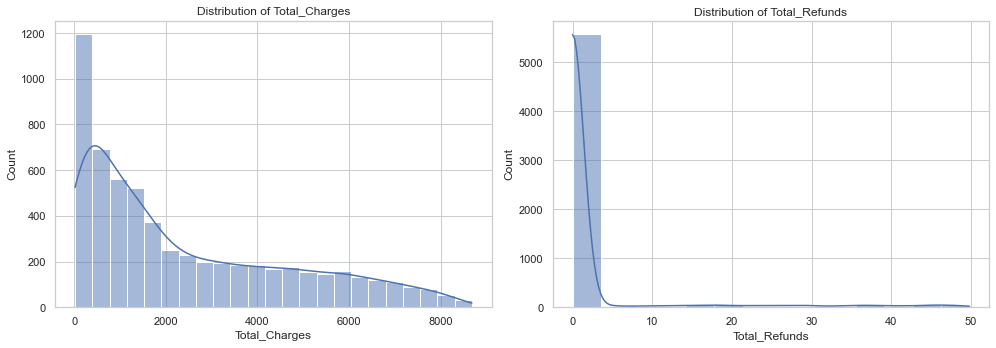

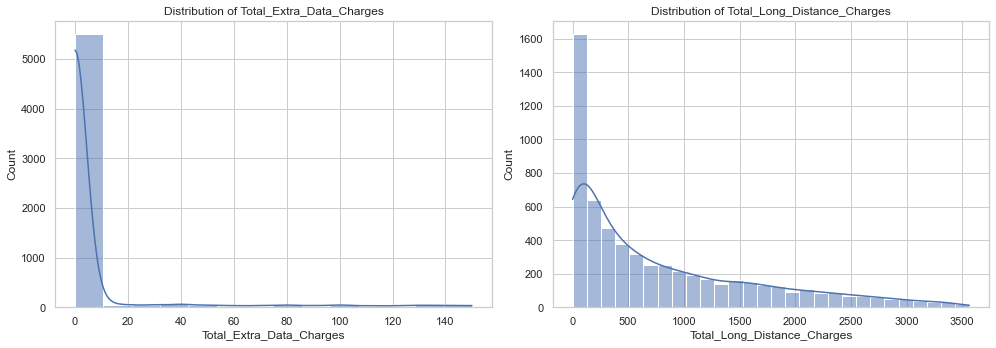

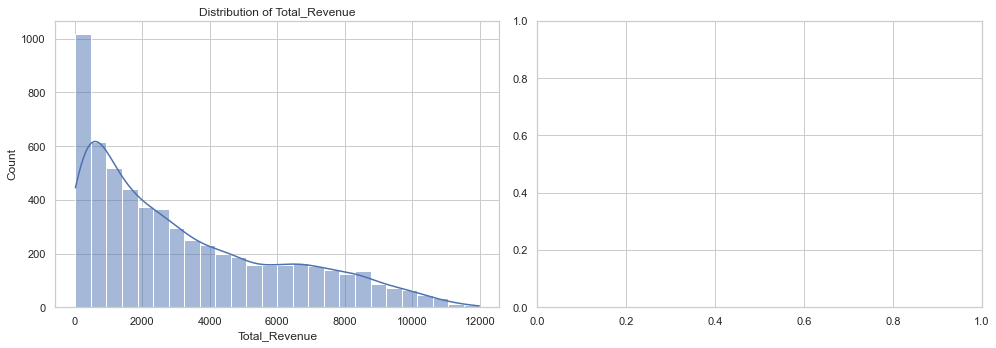

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)   # Width increased for 2 plots in a row

# Folder to save plots
save_dir = "output/eda_plots/univariate"
os.makedirs(save_dir, exist_ok=True)

# IDENTIFY NUMERIC & CATEGORICAL VARIABLES

numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric Columns:", numerical_cols)



# UNIVARIATE ANALYSIS — NUMERIC COLUMNS

for i in range(0, len(numerical_cols), 2):
    fig, axes = plt.subplots(1, 2)

    for j in range(2):
        if i + j < len(numerical_cols):
            col = numerical_cols[i + j]
            sns.histplot(df[col], kde=True, ax=axes[j])
            axes[j].set_title(f"Distribution of {col}")
            axes[j].set_xlabel(col)
            axes[j].set_ylabel("Count")
 
    plt.tight_layout()
    plt.savefig(f"{save_dir}/numeric_{i}.png")
    plt.show()



In [11]:
# Bivariate Analysis (Feature vs Target Variable)

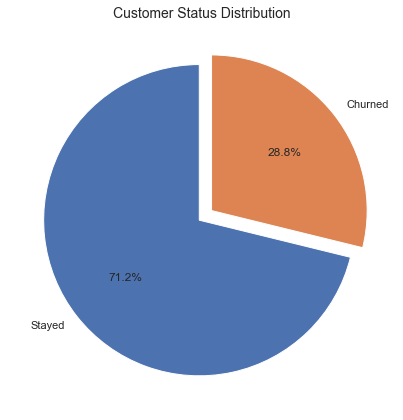

In [12]:
# ----------------- Churn Distribution (Pie Chart) -----------------
plt.figure(figsize=(6, 6))

status_counts = df['Customer_Status'].value_counts()


plt.pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    explode=[0.02, 0.08]  # slight pop-out for emphasis
)

plt.title("Customer Status Distribution", fontsize=14)
plt.tight_layout()
plt.show()



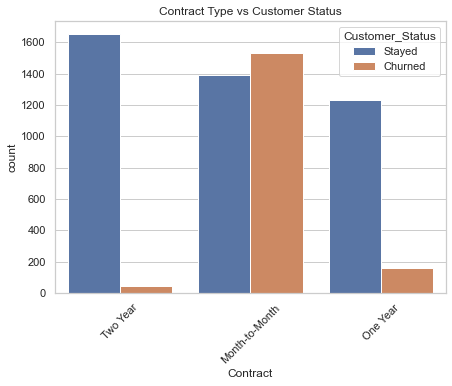

In [13]:
# ----------------- Contract Type vs Churn -----------------
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='Contract', hue='Customer_Status')
plt.title("Contract Type vs Customer Status")
plt.xticks(rotation=45)
plt.show()

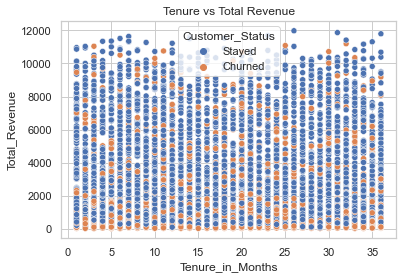

In [14]:
# ----------------- Revenue vs Tenure -----------------
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='Tenure_in_Months', y='Total_Revenue', hue='Customer_Status')
plt.title("Tenure vs Total Revenue")
plt.show()

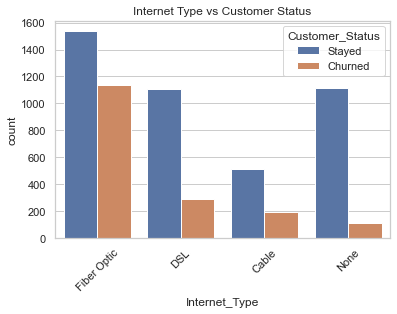

In [19]:
# ----------------- Churn by Internet Type -----------------
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Internet_Type', hue='Customer_Status')
plt.title("Internet Type vs Customer Status")
plt.xticks(rotation=45)
plt.show()


In [20]:
# Correlation & Multicollinearity

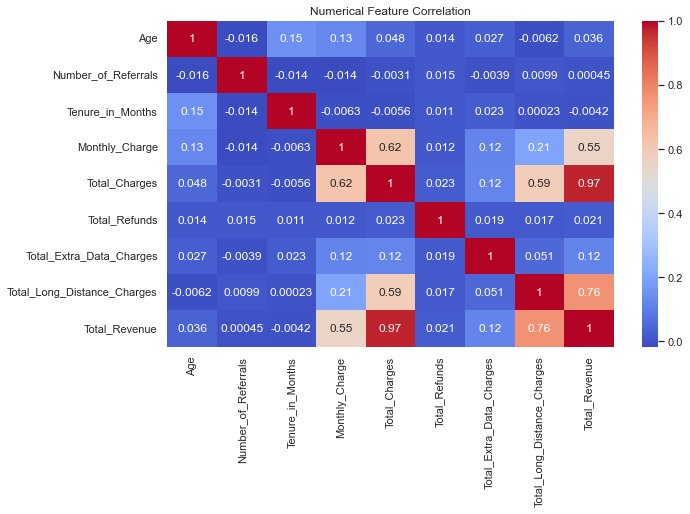

In [22]:
# ----------------- Correlation Heatmap -----------------
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Numerical Feature Correlation")
plt.show()

# Churn Prediction using Random-Forest

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

In [24]:
# LOAD & PREPARE TRAINING DATA

train_df = df.copy()
print("Loaded training data:", train_df.shape)

# Columns to drop
drop_columns = ['Customer_ID', 'Churn_Category', 'Churn_Reason']
train_df = train_df.drop(columns=drop_columns)

# Encode target
train_df['Customer_Status'] = train_df['Customer_Status'].map({"Stayed": 0, "Churned": 1})

# Label encode categorical variables
label_encoders = {}
categorical_cols = train_df.select_dtypes(include="object").columns

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le

# Train test split
X = train_df.drop("Customer_Status", axis=1)
y = train_df["Customer_Status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Loaded training data: (6007, 32)


In [25]:
# TRAIN MODEL

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",   # Handles imbalance
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)


Confusion Matrix:
 [[786  61]
 [136 219]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89       847
           1       0.78      0.62      0.69       355

    accuracy                           0.84      1202
   macro avg       0.82      0.77      0.79      1202
weighted avg       0.83      0.84      0.83      1202



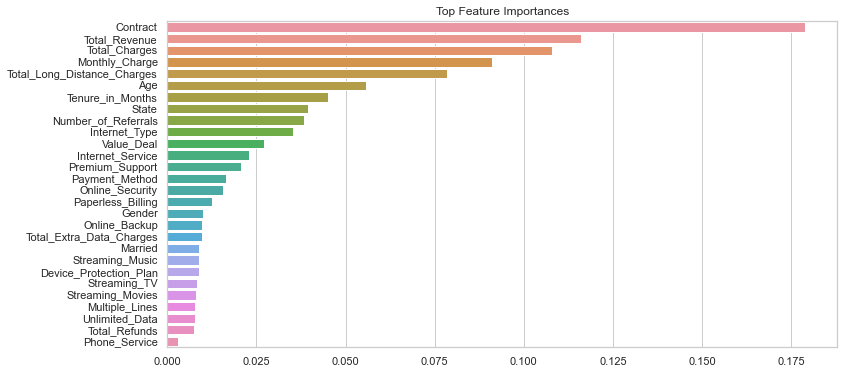


Model and encoders saved successfully.


In [27]:
# EVALUATE MODEL

y_pred = rf_model.predict(X_test)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature importance plot
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top Feature Importances")
plt.show()

# Save model and encoders
joblib.dump(rf_model, "model/rf_churn_model.pkl")
joblib.dump(label_encoders, "model/label_encoders.pkl")

print("\nModel and encoders saved successfully.")


In [30]:
# PREDICT NEW CUSTOMERS' CHURN STATUS
file_path = r"dataset/telecom.xlsx"

# Define the sheet name to read data from
sheet_name = 'vw_JoinData'

predict_df = pd.read_excel(file_path, sheet_name = sheet_name)
customer_ids = predict_df["Customer_ID"]
raw_df = predict_df.copy()

# Drop unused columns
predict_df = predict_df.drop(columns=['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'])

# Apply encoding
for col in predict_df.select_dtypes(include="object").columns:
    predict_df[col] = label_encoders[col].transform(predict_df[col])

# Predict churn
raw_df["Churn_Predicted"] = rf_model.predict(predict_df)

# Extract churn customers
churn_customers = raw_df[raw_df["Churn_Predicted"] == 1]
churn_customers.to_csv("dataset/Predictions.csv", index=False)

print("\nPrediction file generated: Predictions.csv")


Prediction file generated: Predictions.csv
